# Qubit Mapping


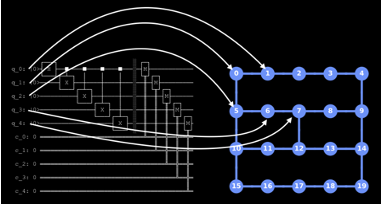

Mapping is the process of taking qubits from an algorithmic "abstract" framework to the physical ones existing on an actual quantum backend. There are two considerations when mapping a quantum circuit to a backend: the fact that most physical backends have limited qubit connectivity and the quality of the physical qubits. Selection of *good* qubits together with minimizing the number of SWAP gates arising from limited qubit connectivity are often orthogonal requirements.

Therefore, we separate qubit mapping into **two** distinct sequential processes (which also reflects that they are solved by two separate classical algorithms):

- **Routing**: Finding the least number of `SWAP` gates needed to route quantum information given limited connectivity.
  
- **Layout**: Finding the best qubits (given some metric or cost function) that respects the topology given by the Routing pass.

The second process is the primary topic of discussion in this notebook.

Note that both of these problems are NP-hard, and hence we use stochastic algorithms SABRE and VF2, respectively. For better performance, especially on larger number of qubits, consider running each several times, using the metrics

- `qc.count_ops()['swap']` for SABRE routing
- `scored_layouts[0][1]` for VF2 layout
  
where lower is better.

## Start
We shall test out the method on n-qubit GHZ circuit, whose state is given by
$$
|\psi_{\rm GHZ}\rangle = \frac{1}{\sqrt{2^n}} \left( |0\rangle^{\otimes n} + |1\rangle^{\otimes n} \right)
$$.

## Build

We shall look into the first example having only 5-qubits. Having a smaller circuit will help us visualize the steps, and the final outcome more clearly in the form of a histogram. Later, we shall move to bigger GHZ circuits.

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options

In [2]:
service = QiskitRuntimeService()

In [3]:
backend = service.get_backend('ibm_peekskill')

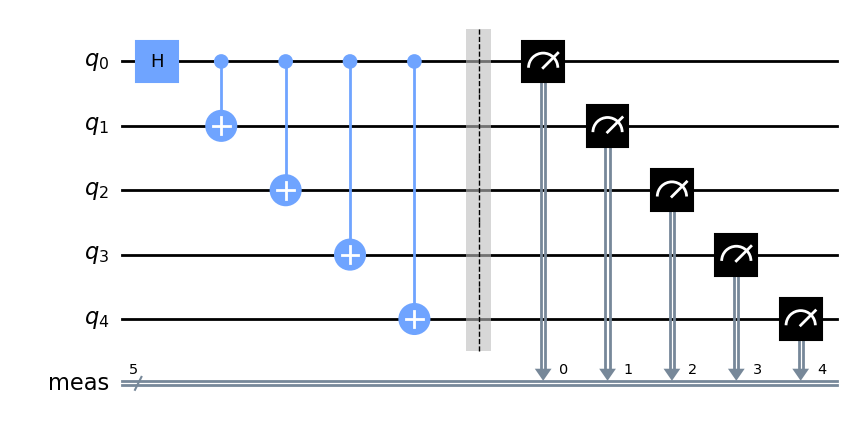

In [4]:
num_qubits = 5

ghz_small = QuantumCircuit(num_qubits)
ghz_small.h(0)
[ghz_small.cx(0,i) for i in range(1,num_qubits)]
ghz_small.measure_all()
ghz_small.draw('mpl')

Some of you may notice that this is not the most optimal way to create a GHZ state. However, for the 5-qubit example, we stick to this circuit since it will help us visualize a few things better.

## Transpile

### Routing

First we shall transpile the circuit without worrying about the qubit qualities. Given the limited topology of current backends (a qubit in a heavy-hex device has at most 3 connected qubits), this circuit guarantees that at least one `SWAP` gate is needed. We transpile the circuit with `optimization_level=2` to avoid stochastic passes introduced in `optimization_level=3`. First, we check that SWAP gates are indeed required by using a `pass_manager`.

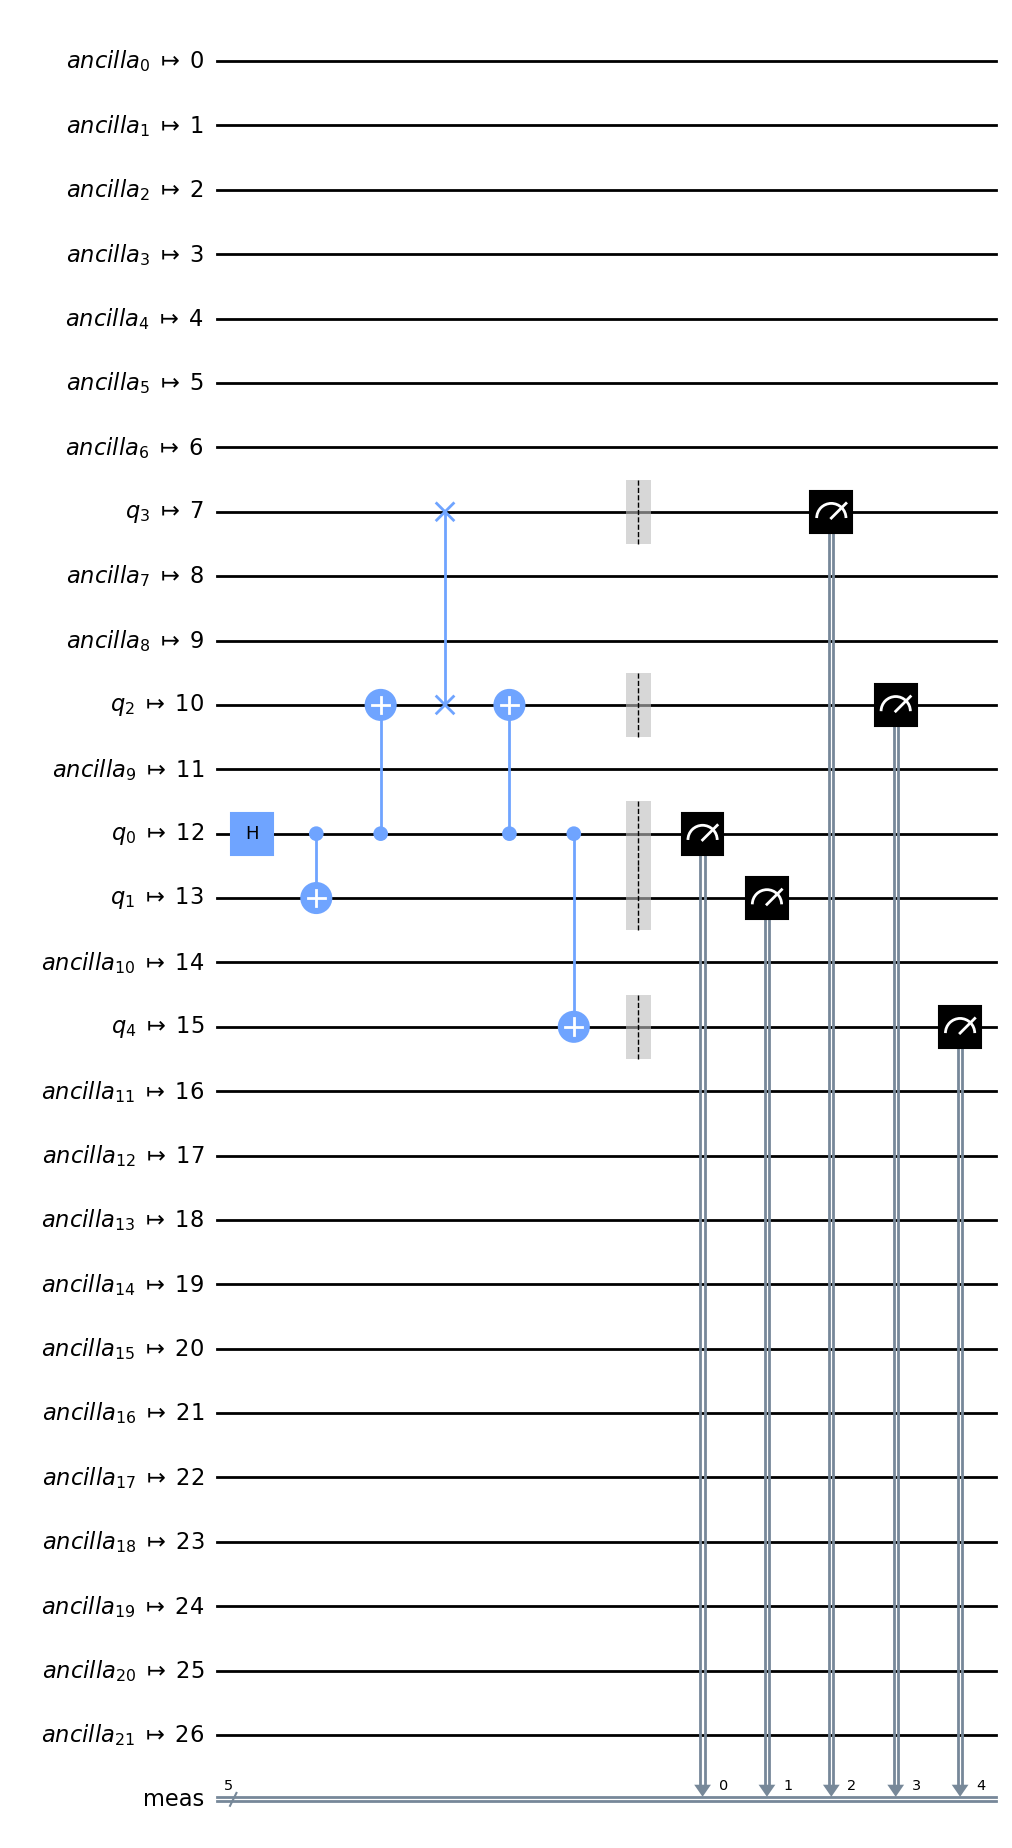

In [5]:
pm = generate_preset_pass_manager(2, backend)
ghz_small_pm = pm.layout.run(ghz_small)
ghz_small_pm.draw('mpl')

### Layout

Now we use a tool called `mapomatic`, a wrapper for the VF2 algorithm, to find the least error-prone qubits for the given topology found in the routing stage. The error is specified by a default `cost_function` that multiplies the fidelities of all the gate operations together and inverts it for a type of "infidelity score" (the lower the better). This proceeds in four steps.

- **Step 1:** The first step is to translate the circuit into the basis gate set. This is necessary for scoring since the calibration data are available only for these gates.

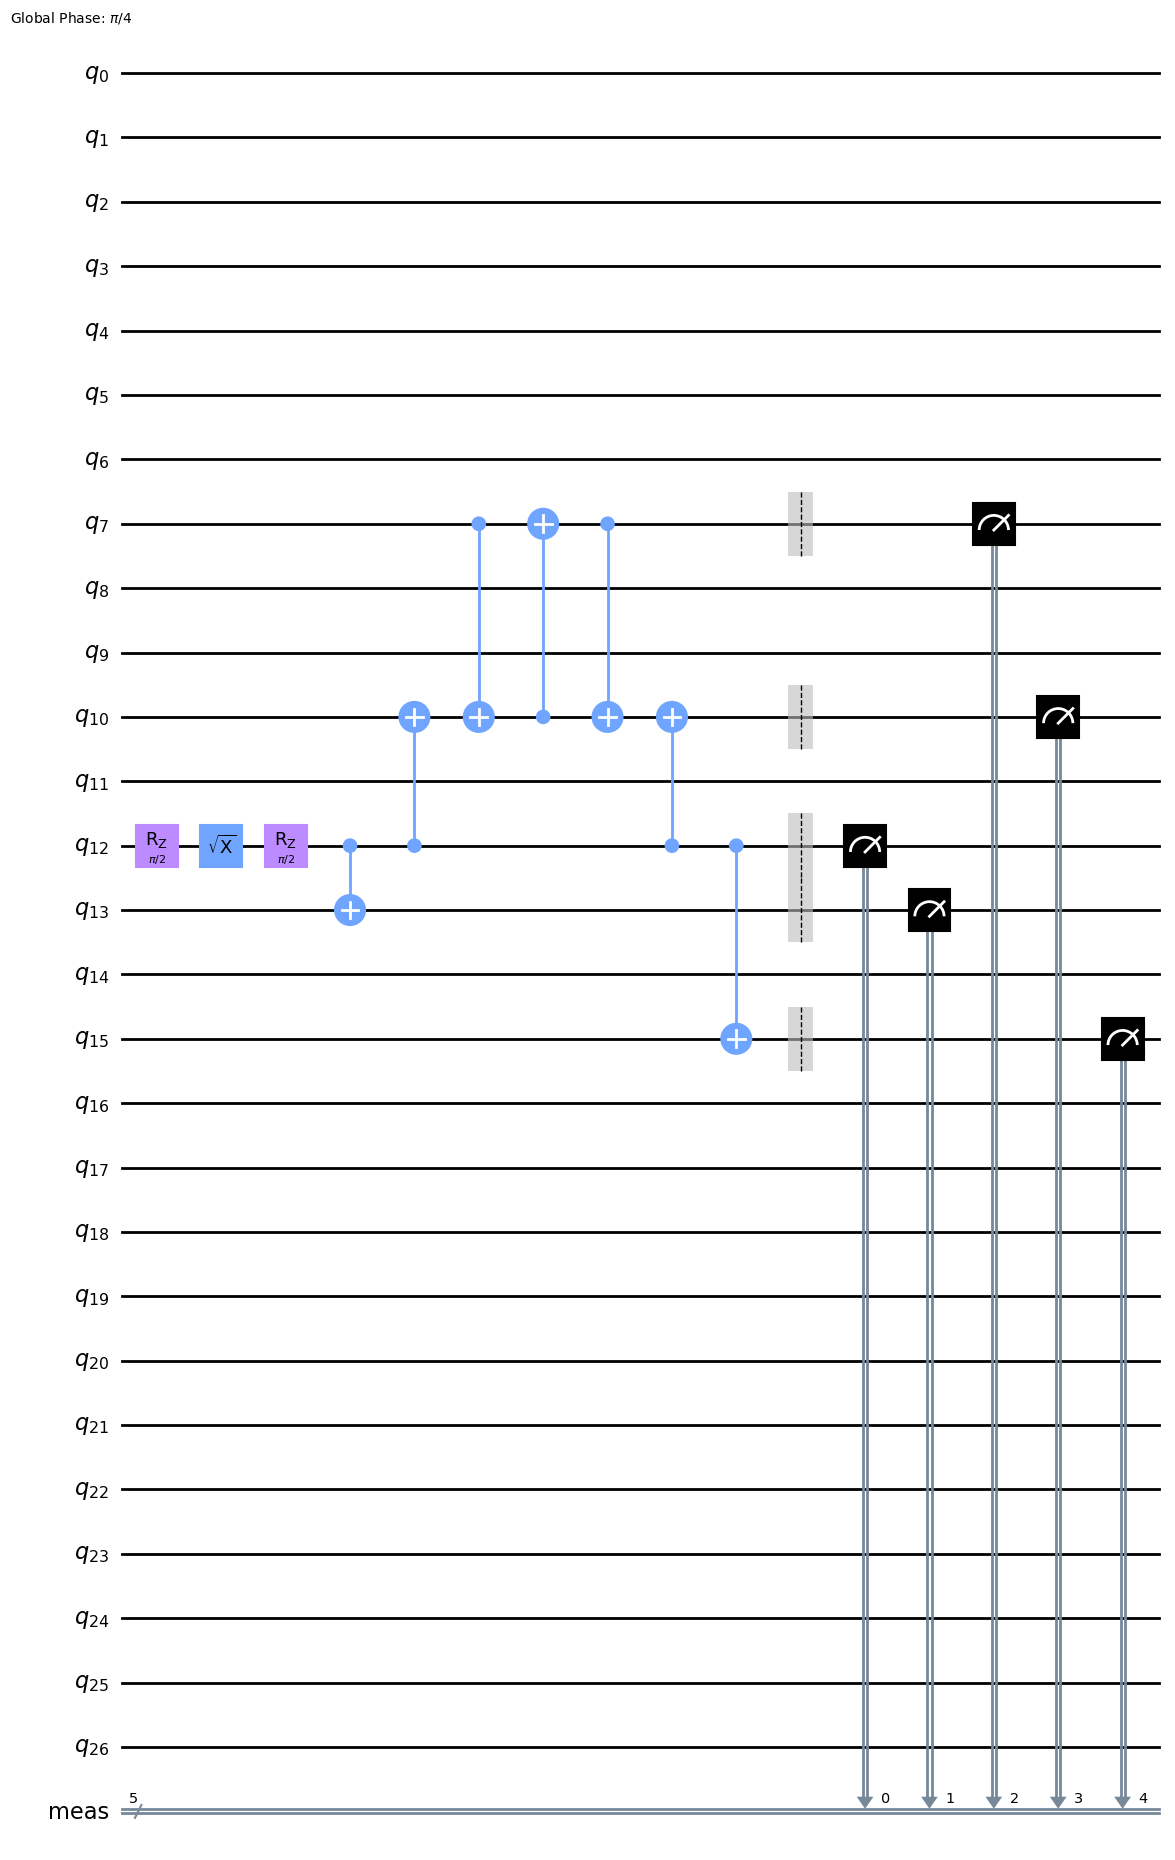

In [7]:
ghz_small_trans = pm.translation.run(ghz_small_pm)
ghz_small_trans.draw('mpl')

Now that we only have basis gates remaining (`rz`, `sx`, and `cx`), it is time for

- **Step 2**: The transpiled circuit now consists of 27 qubits, out of which only 5 are associated with the circuit, while the others are ancilla. We first want to get rid of those anciall qubits. We use the `deflate_circuit` from `mapomatic` for this.

   - Step 2a: Install `mapomatic` if you have not already.

In [25]:
# !pip install mapomatic

In [8]:
import mapomatic as mm

- 
   - Step 2b: Deflate the circuit.

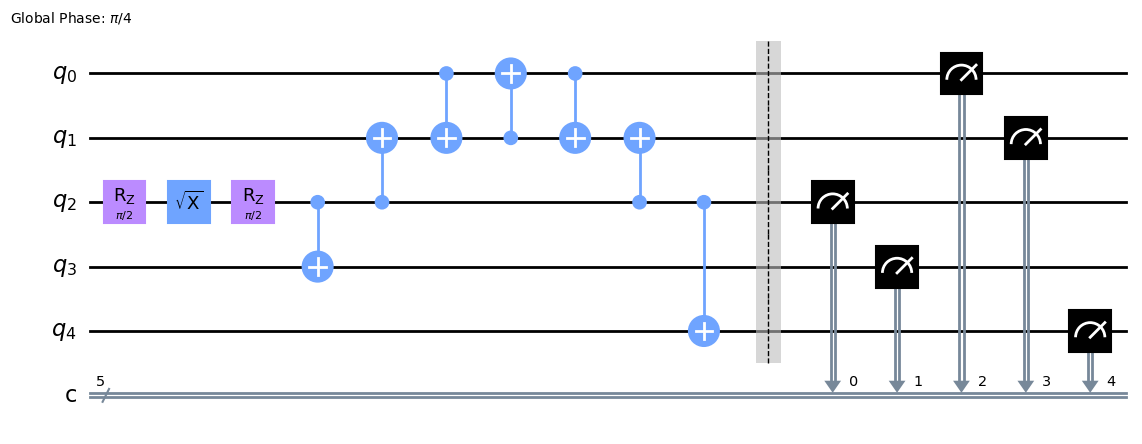

In [9]:
ghz_small_df = mm.deflate_circuit(ghz_small_trans)
ghz_small_df.draw('mpl')

- **Step 2**: Find all possible layouts such that the they are isomorphic to the original transpiled circuit. We only print the first five layouts for brevity.

In [10]:
layouts = mm.matching_layouts(ghz_small_df, backend.configuration().coupling_map)

layouts[:5]

[[3, 2, 1, 4, 0],
 [3, 2, 1, 0, 4],
 [7, 4, 1, 2, 0],
 [7, 4, 1, 0, 2],
 [1, 4, 7, 10, 6]]

- **Step 3**: Now we score each layout using the calibration data. Note that the default scoring function uses information of gate error, SPAM and T1, T2 error on idle time. However, `mapomatic` also allows the user to write their own custom scoring function.

In [11]:
# add description about cost function
scored_layouts = mm.evaluate_layouts(ghz_small_df, layouts, backend)

In [12]:
# The best layout is the one with minimum score
best_layout = scored_layouts[0]
best_layout

([3, 5, 8, 9, 11], 0.06590946418140065)

- **Step 4:** Pick the best layout and construct a new pass manager from it. Then use that to transpile the circuit.

In [13]:
from qiskit.transpiler import Layout

layout = Layout().from_intlist(best_layout[0], *ghz_small_df.qregs)

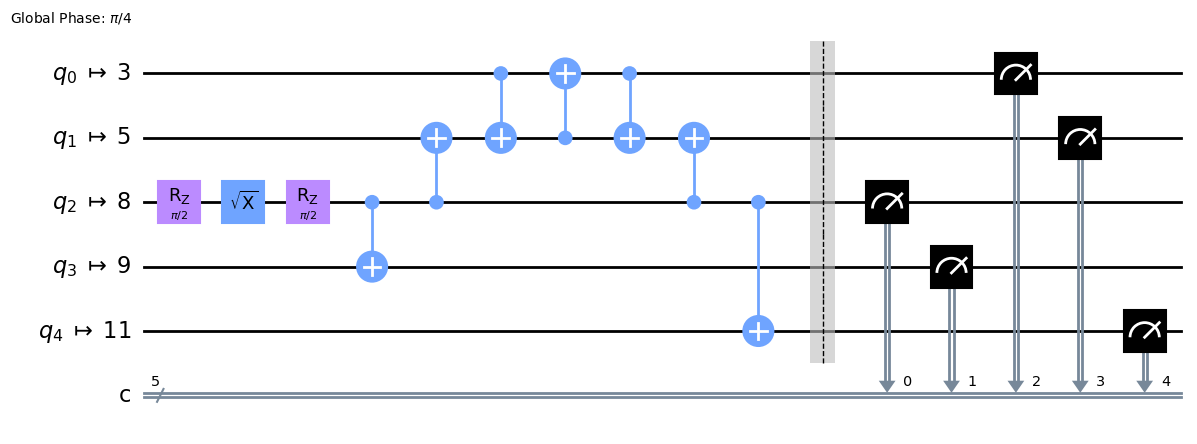

In [14]:
pm = generate_preset_pass_manager(2, backend, initial_layout=layout)
qc = pm.layout.run(ghz_small_df)
qc.draw('mpl', idle_wires=False, fold=-1)

As discussed, multiple inputs from calibration data goes into the scoring of the layouts. However, note that in the unoptimized transpilation, there are 4 CNOT operations between `q7`-`q10`. These CNOT operations are between `q3`-`q5` in the optimized version.

As an exercise, let's confirm `q3`-`q5` has a lower `cx` error than `q7`-`q10`.

In [15]:
props = backend.properties()
conf = backend.configuration()

print(f'Error probability of q3-q5 is {props.gate_error("cx", qubits=[3,5])} while that of q7-q10 is {props.gate_error("cx", qubits=[7,10])}')

Error probability of q3-q5 is 0.002915914970980371 while that of q7-q10 is 0.006988617705936673


## Verify

The ideal output of the GHZ state is $|0\rangle^{\otimes 5}$ with probability 0.5 and $|1\rangle^{\otimes 5}$ with probability 0.5. So we skip the computation on an ideal simulator.

In [16]:
sim_result = {'0'*5:0.5, '1'*5:0.5}
sim_result

{'00000': 0.5, '11111': 0.5}

## Run

Finally, we run the transpiled circuit on the hardware using the Runtime. To compare, we also run the transpiled circuit without picking the best qubits to use. Termed as "unoptimized". Do `skip_transpilation = True` since the circuits are already transpiled.

In [17]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 0
options.transpilation.skip_transpilation = True

sampler = Sampler(backend = backend, options=options)

optimized_job = sampler.run(qc, shots=10000)

In [18]:
# comparison
unoptimized_job = sampler.run(ghz_small_trans, shots=10000)

In [19]:
# get result
unoptimized_result = unoptimized_job.result().quasi_dists[0].binary_probabilities()
optimized_result = optimized_job.result().quasi_dists[0].binary_probabilities()

### We now plot the ideal, optimized and unoptimized counts

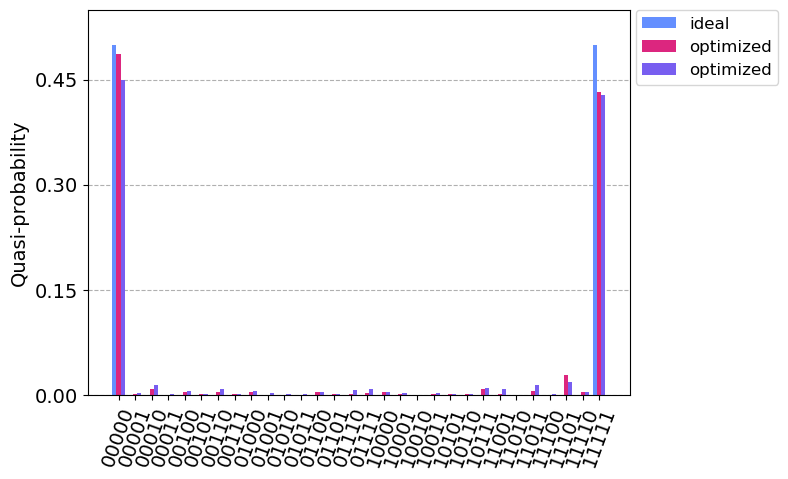

In [21]:
from qiskit.visualization import plot_histogram

plot_histogram(
    [result for result in [sim_result, optimized_result, unoptimized_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "optimized",
        "optimized",
    ],
)

It is clear from the histogram plot that the outcome of the circuit execution with layout selected by `mapomatic` is much closer to the ideal outcome as opposed to the one without it. This clearly shows the importance of good qubit selection, and the effectiveness of `mapomatic` for the same.

### Bigger circuits

We now show a similar example with a GHZ circuit including 20 qubits. Here, we use a better GHZ state preparation circuit which has a lower depth.

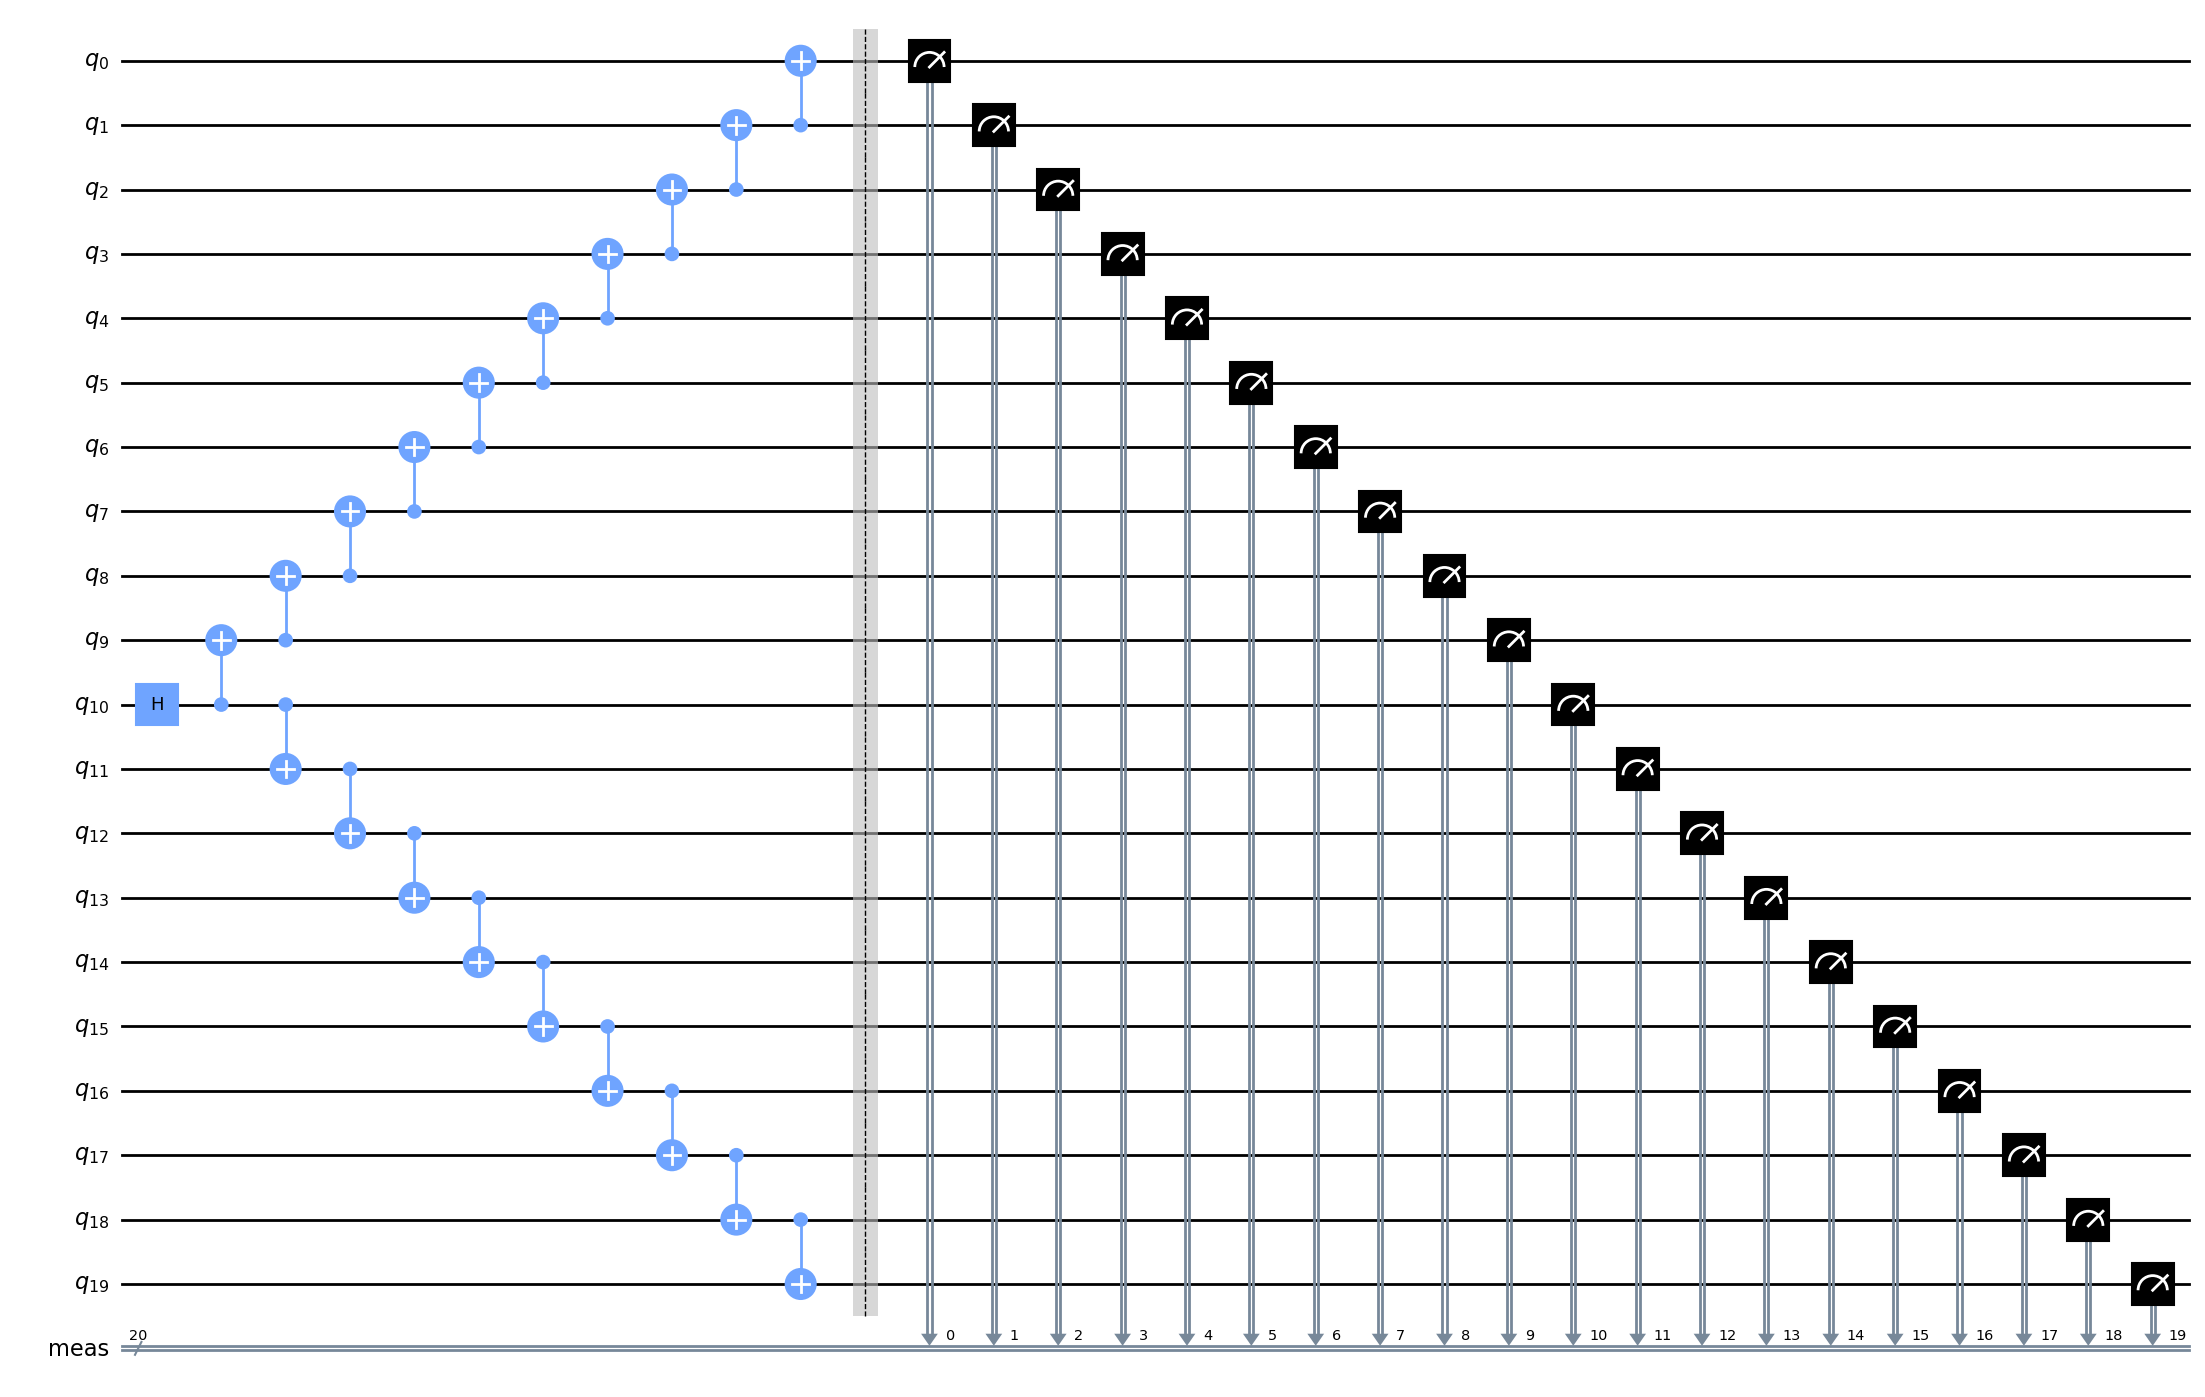

In [45]:
num_qubits = 20

ghz = QuantumCircuit(num_qubits)
mid = num_qubits//2
ghz.h(mid)
[ghz.cx(i,i-1) for i in range(mid,0,-1)]
[ghz.cx(j,j+1) for j in range(mid,num_qubits-1)]
ghz.measure_all()

ghz.draw('mpl',fold=-1)

As before, we use a `pass_manager` to map the circuit to the backend.

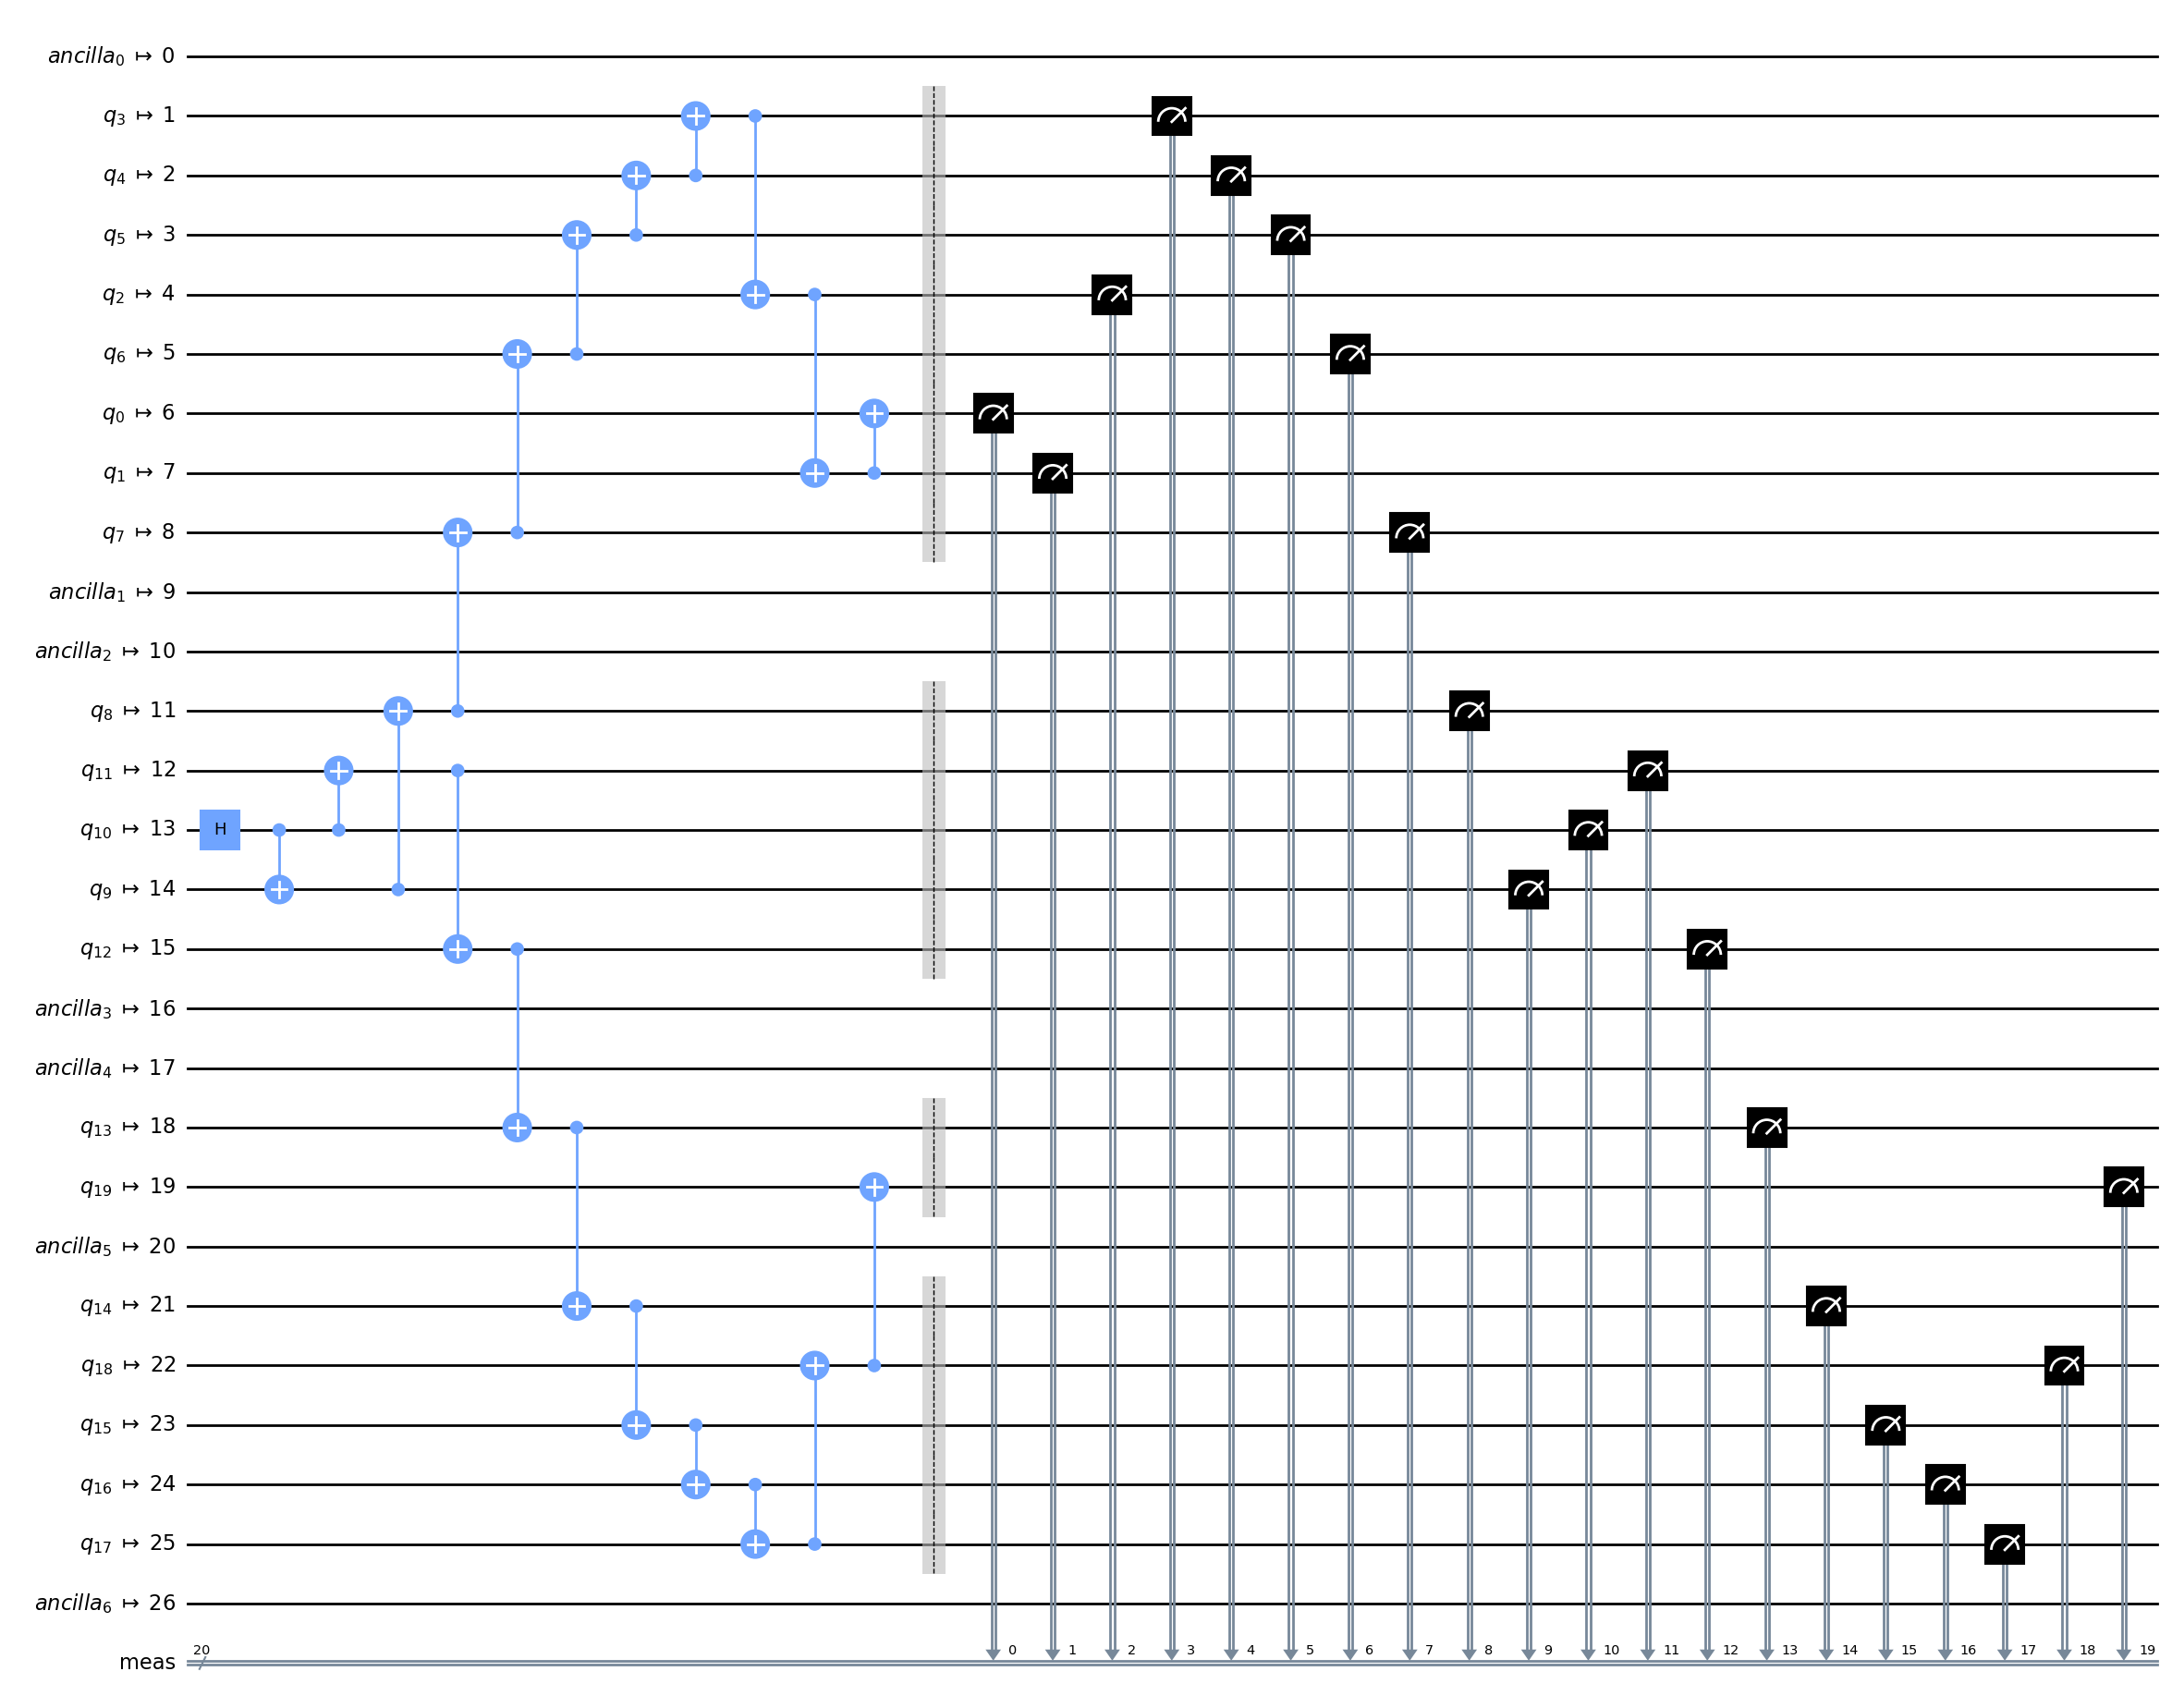

In [46]:
pm = generate_preset_pass_manager(2, backend)
ghz_pm = pm.layout.run(ghz)
ghz_pm.draw('mpl',fold=-1)

Next, translate the circuit to include only basis gates

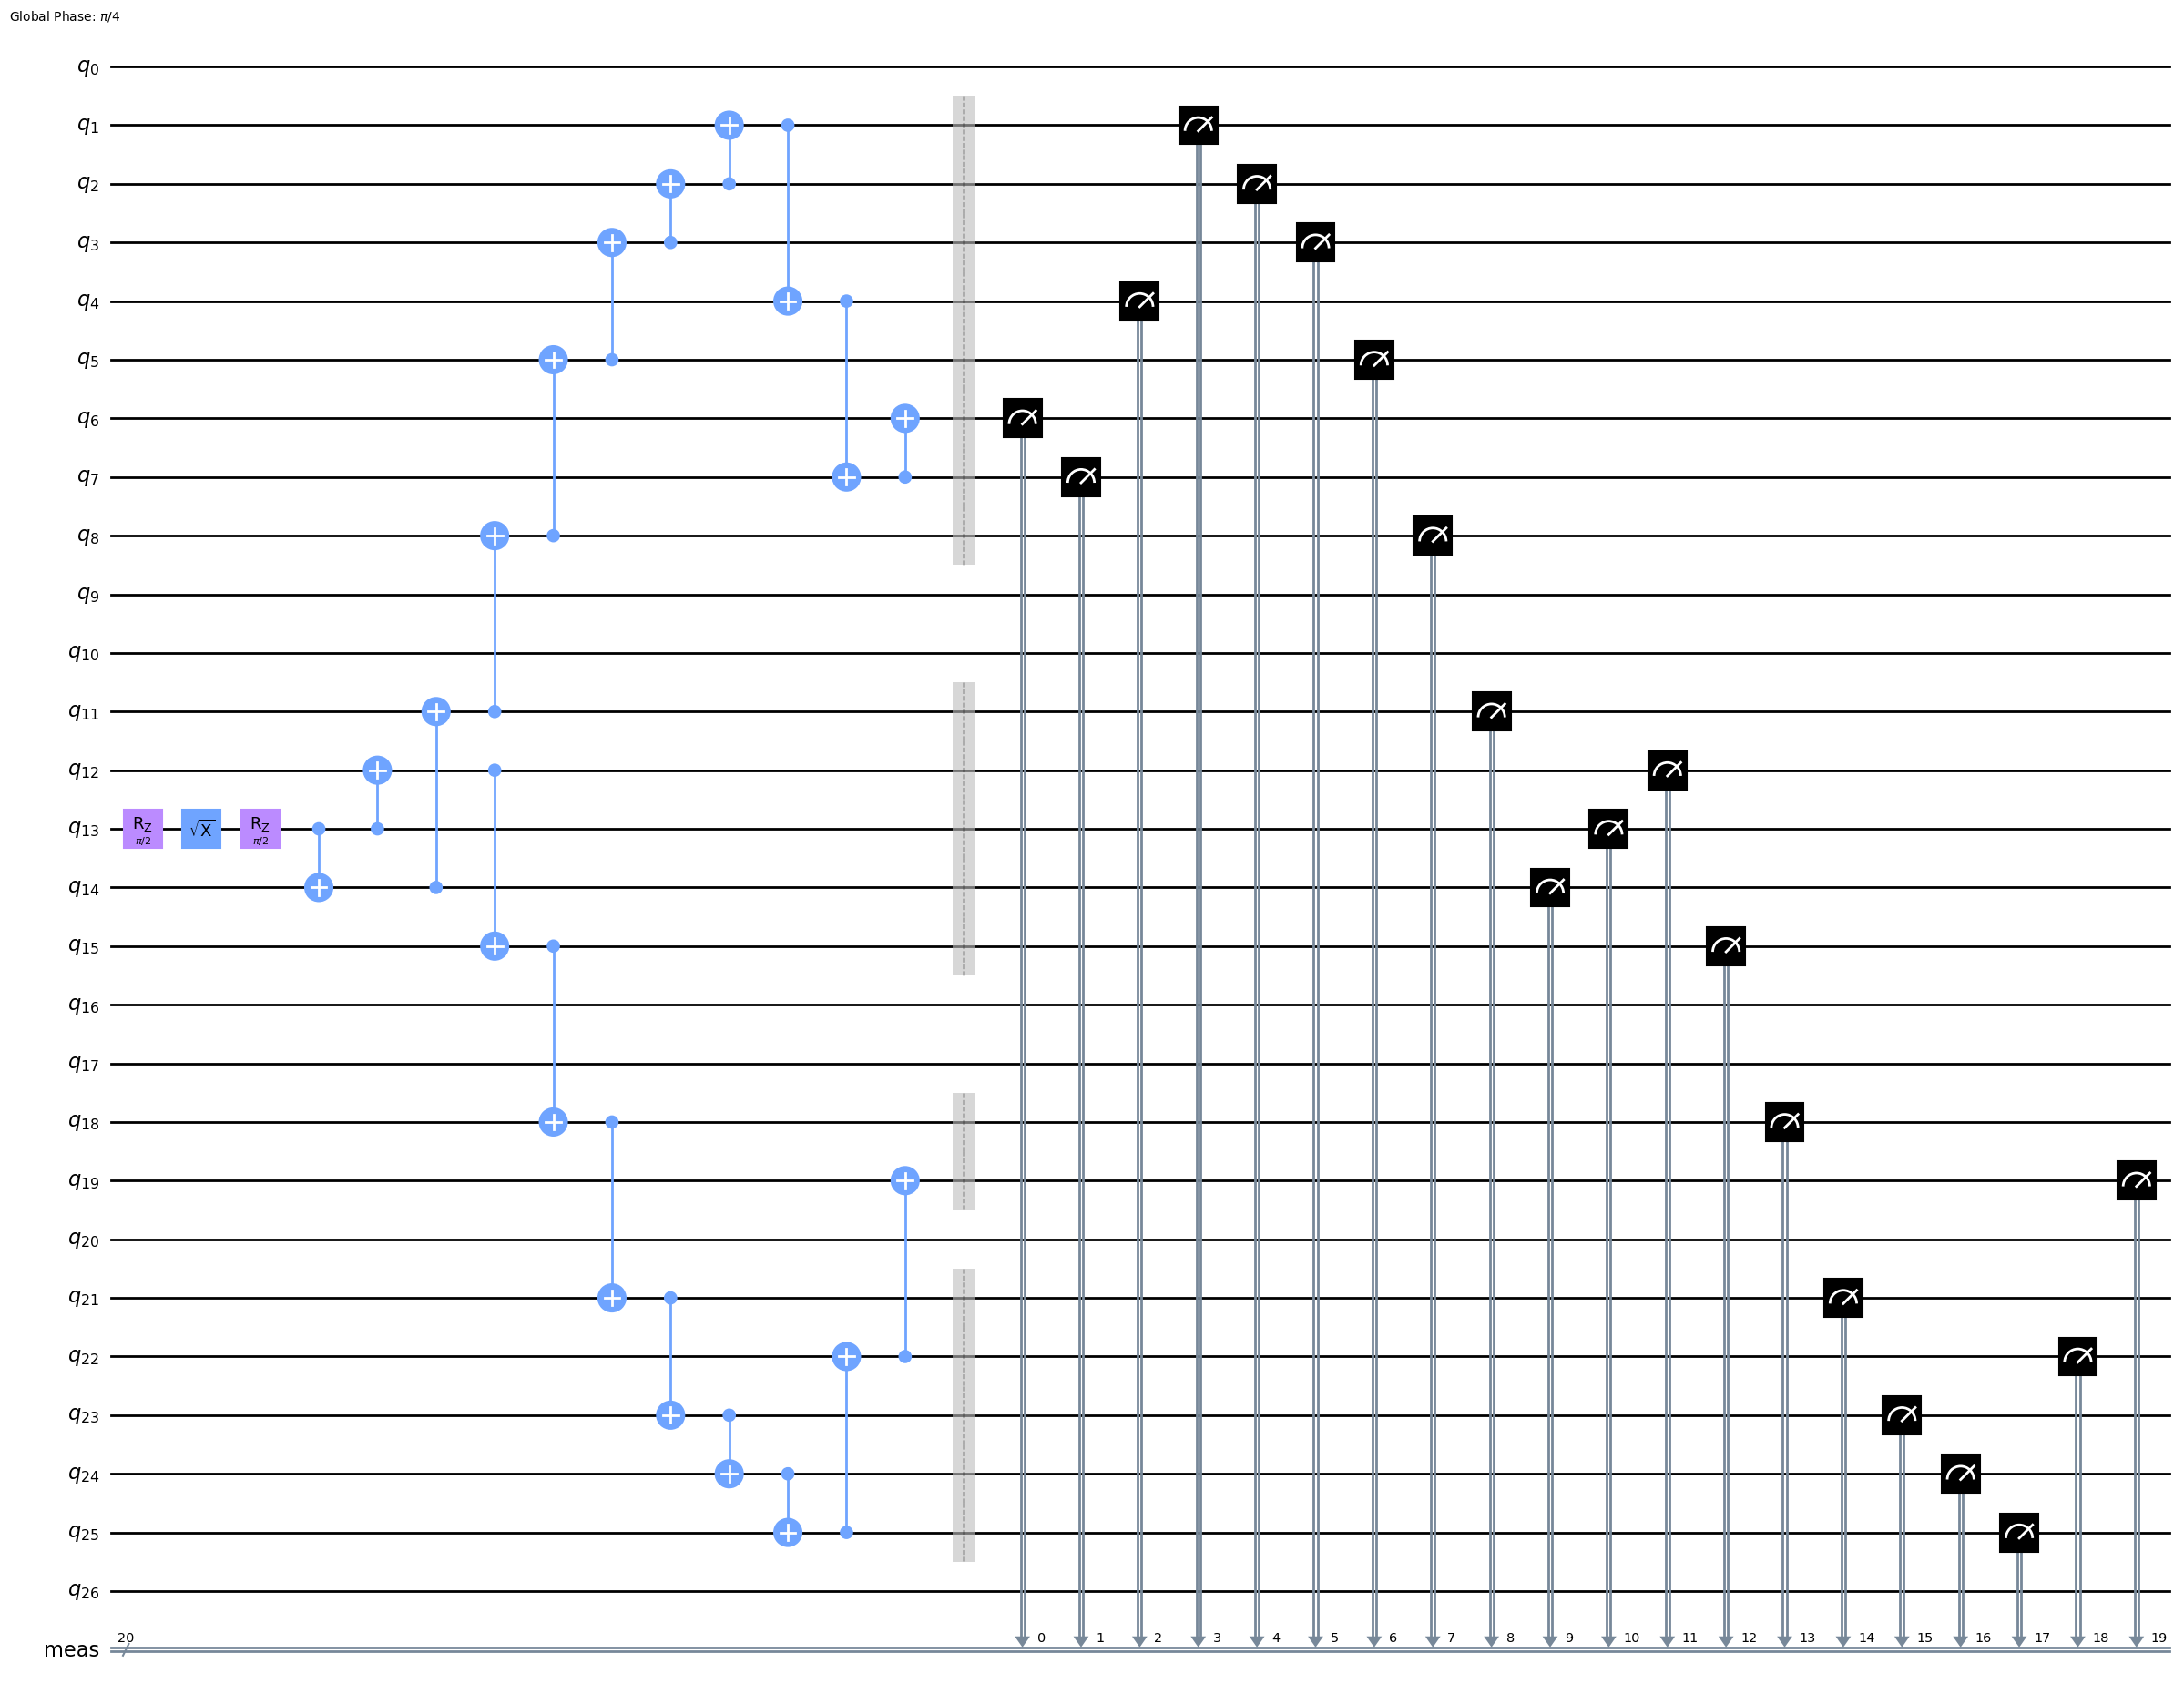

In [47]:
ghz_trans = pm.translation.run(ghz_pm)
ghz_trans.draw('mpl',fold=-1)

Now we deflate the circuit to remove the ancilla qubits and find all the matching layouts. Note that since, in this example, the circuit is almost as big as the hardware itself, the number of possible layouts will be much less than the previous example.

In [48]:
ghz_df = mm.deflate_circuit(ghz_trans)
layouts = mm.matching_layouts(ghz_df, backend.configuration().coupling_map)

Now, we score all the layouts using calibration data, and select the one with the minimum score.

In [49]:
scored_layouts = mm.evaluate_layouts(ghz_df, layouts, backend)
best_layout = scored_layouts[0]

layout = Layout().from_intlist(best_layout[0], *ghz_df.qregs)
pm = generate_preset_pass_manager(2, backend, initial_layout=layout)
qc = pm.layout.run(ghz_df)

As before, for GHZ circuit, the ideal simulation result is well known

In [50]:
ideal = {'0'*num_qubits:0.5, '1'*num_qubits:0.5}

In [58]:
## Now we run the optimized and unoptimized transpiled circuits

optimized_job = sampler.run(qc, shots=10000)
unoptimized_job = sampler.run(ghz_trans, shots=10000)

In [59]:
# get result
unoptimized_result = unoptimized_job.result().quasi_dists[0].binary_probabilities()
optimized_result = optimized_job.result().quasi_dists[0].binary_probabilities()

Note that a histogram will be largely illegible for a 20 qubit circuit. So we would rather look into the fidelity of the two circuit executions with the ideal distribution.

In [41]:
from qiskit.quantum_info import hellinger_fidelity

In [60]:
print(f'The fidelity of the uoptimized circuit with the ideal simulation result is {hellinger_fidelity(unoptimized_result, ideal)}')

The fidelity of the uoptimized circuit with the ideal simulation result is 0.4351726979322706


In [61]:
print(f'The fidelity of the optimized circuit using mapomatic with the ideal simulation result is {hellinger_fidelity(optimized_result, ideal)}')

The fidelity of the optimized circuit using mapomatic with the ideal simulation result is 0.452423040668757


**Inference** - It can be noted that for a 20 qubit circuit the increase in fidelity is not significant. This is expected because for a circuit of this size, noise plays a significant role and other error mitigation techniques should be used for improved quality of result. However, even at this scale, the improvement provided by mapomatic is visible.